In [6]:
import pandas as pd
import numpy as np
import sys,os
import glob
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.patches import Ellipse
import seaborn as sns
%matplotlib inline 
sns.set_style('darkgrid')

#########################
# get all data 挑选high data
#########################
data_dir = '/home/jlk/Project/111_Cmap/MOA/analysis/plot_demention/MOA_pari_data'
sig2drugmoa_file = '{}/sig2drugmoa.npz'.format(data_dir)
drug2moa_file = '{}/drug2moa.npz'.format(data_dir)
sig2cell_file = '{}/sig2cell.npz'.format(data_dir)
data_file = '{}/all_signature_high_quality.h5'.format(data_dir)

sig2drugmoa_dict = np.load(sig2drugmoa_file)
drug2moa_dict = np.load(drug2moa_file)
sig2cell_dict = np.load(sig2cell_file)

# load data
data_df = pd.read_hdf(data_file)

# MCF7 data
cell_label = [sig2cell_dict[i] for i in data_df.index]
index = np.where(np.isin(cell_label,['MCF7']),True,False)

data_cell_df = data_df.loc[index]
print(data_df.shape,data_cell_df.shape)

moa_label = [sig2drugmoa_dict[i][1] for i in data_cell_df.index]

print('Paired moas signature number',data_cell_df.shape)

(62374, 12328) (6642, 12328)
Paired moas signature number (6642, 12328)


In [7]:
#############
# stat moa signature number
#############
moas = ['PKC-activator','PKC-i',
        'AR agonist','AR antagonist',
        'SIRT-activator','SIRT-i',
        'ER agonist','ER antagonist',
        'caspase-i','caspase-activator',
        'AMPK-i','AMPK-activator']

moa_counts = Counter(moa_label)
for moa in moas:
    print(moa,moa_counts[moa])

PKC-activator 35
PKC-i 42
AR agonist 8
AR antagonist 7
SIRT-activator 0
SIRT-i 12
ER agonist 58
ER antagonist 23
caspase-i 0
caspase-activator 11
AMPK-i 0
AMPK-activator 0


In [8]:
##################
# all data
##################
moas = ['PKC-activator','PKC-i',
        'AR agonist','AR antagonist',
        'ER agonist','ER antagonist']

moa_name = {'PKC-activator':'PKC-activator',
            'PKC-i':'PKC-inhibitor',
            'AR agonist':'AR-agonist',
            'AR antagonist':'AR-antagonist',
            'ER agonist':'ER-agonist',
            'ER antagonist':'ER-antagonist'}

plot_data_x = data_cell_df.values
plot_data_y = [sig2drugmoa_dict[i][1] for i in data_cell_df.index]
plot_data_y = np.array(plot_data_y)
# compute
X_tsne = TSNE(n_components=2, random_state=1).fit_transform(plot_data_x)
y = plot_data_y


/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


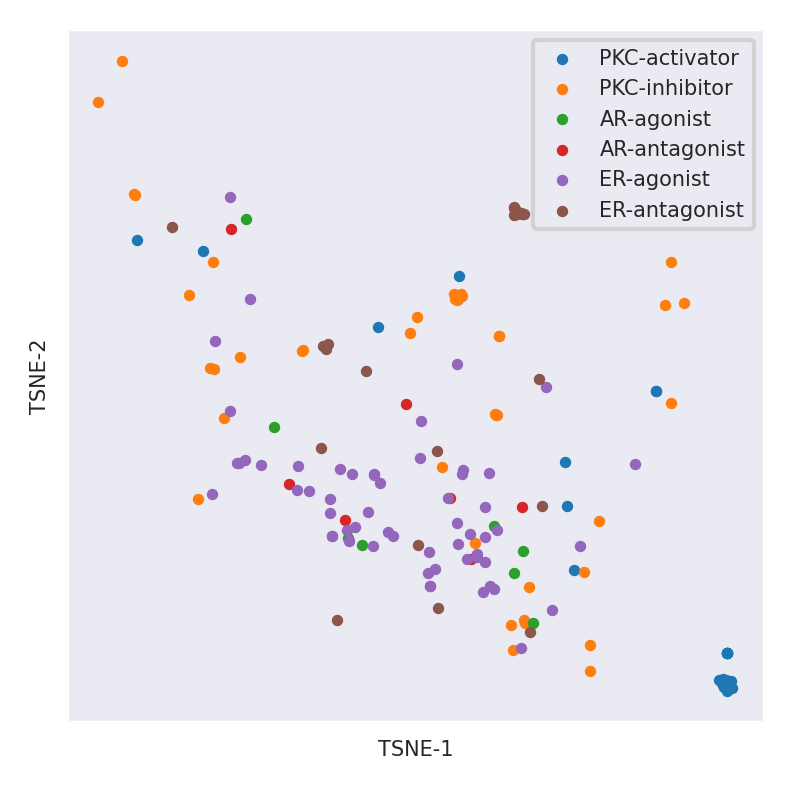

In [9]:
my_dpi=300
plt.figure(figsize=(3,3),dpi=my_dpi)
for i in moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3,label=moa_name[i])

plt.legend(loc='best',fontsize=5)
plt.tick_params(labelsize=6) 
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('TSNE-1',fontsize=5)
plt.ylabel('TSNE-2',fontsize=5)
# plt.show()
plt.savefig('R1_Q3_1.jpg')

In [10]:
##################
# computer plot data
##################

def tsne_pair_data(pair_list):
    index = np.where(np.isin(moa_label,pair_list),True,False)
    data = data_cell_df.loc[index]
    print(data.shape)
    plot_data_x = data.values
    plot_data_y = [sig2drugmoa_dict[i][1] for i in data.index]
    plot_data_y = np.array(plot_data_y)

    # compute
    X_tsne = TSNE(n_components=2, random_state=1).fit_transform(plot_data_x)
    y = plot_data_y
    
    return X_tsne,y

pair1_moas = ['PKC-activator','PKC-i']
pair2_moas = ['AR agonist','AR antagonist']
# pair3_moas = ['SIRT-activator','SIRT-i',]
pair4_moas = ['ER agonist','ER antagonist']
# pair5_moas = ['caspase-i','caspase-activator']
# pair6_moas = ['AMPK-i','AMPK-activator']

p1_x,y1 = tsne_pair_data(pair1_moas)
p2_x,y2 = tsne_pair_data(pair2_moas)
# p3_x,y3 = tsne_pair_data(pair3_moas)
p4_x,y4 = tsne_pair_data(pair4_moas)
# p5_x,y5 = tsne_pair_data(pair5_moas)
# p6_x,y6 = tsne_pair_data(pair6_moas)


(77, 12328)


/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(15, 12328)


/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(81, 12328)


/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


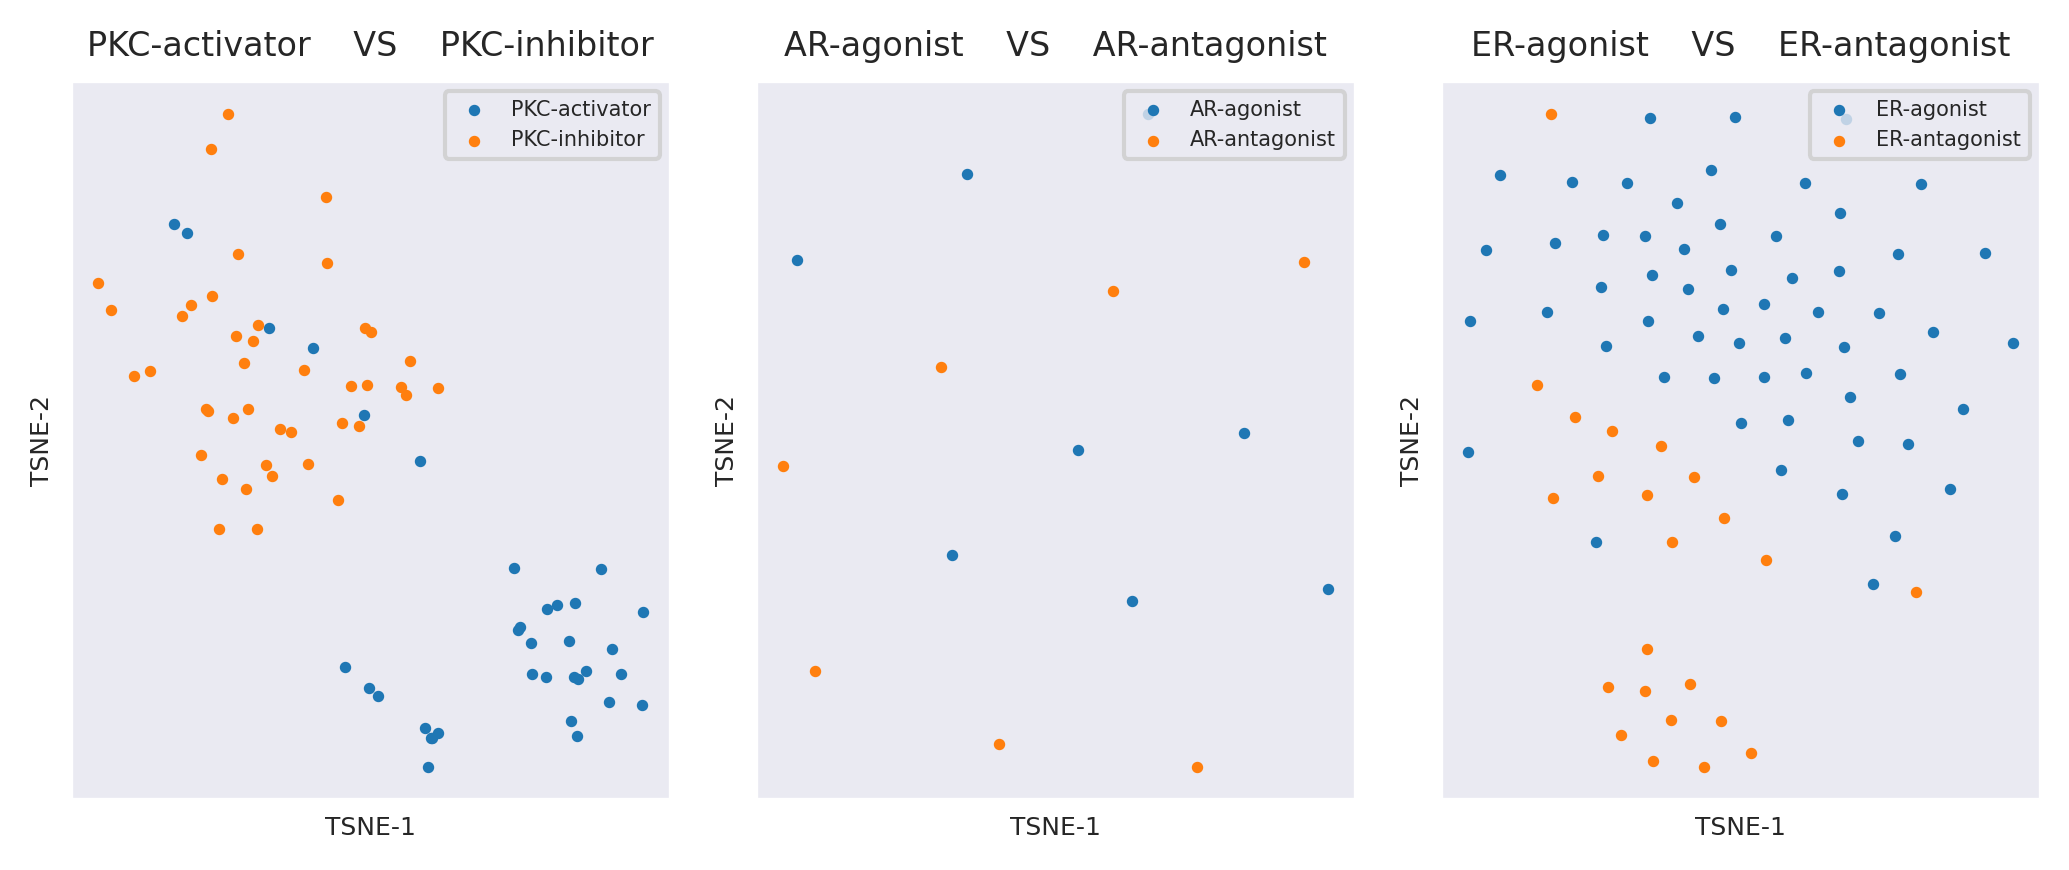

In [14]:
my_dpi=300
plt.figure(figsize=(7,3),dpi=my_dpi)

plt.subplot(131)
X_tsne = p1_x
y = y1
n1 = pair1_moas[0]
n2 = pair1_moas[1]
for i in pair1_moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3,label=moa_name[i])#,label = name_dict[i],color=col_map[i] )
plt.legend(loc='upper right',fontsize=5)
plt.title('{}    VS    {}'.format(moa_name[n1],moa_name[n2]),fontsize=8)
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('TSNE-1',fontsize=6)
plt.ylabel('TSNE-2',fontsize=6)

plt.subplot(132)
X_tsne = p2_x
y = y2
n1 = pair2_moas[0]
n2 = pair2_moas[1]
for i in pair2_moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3,label=moa_name[i])#,label = name_dict[i],color=col_map[i] )
plt.legend(loc='upper right',fontsize=5)
plt.title('{}    VS    {}'.format(moa_name[n1],moa_name[n2]),fontsize=8)
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('TSNE-1',fontsize=6)
plt.ylabel('TSNE-2',fontsize=6)

# plt.subplot(233)
# X_tsne = p3_x
# y = y3
# for i in moas:
#     plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3)#,label = name_dict[i],color=col_map[i] )
#     plt.xticks([],[])
# plt.title('{} VS {}'.format(pair3_moas[0],pair3_moas[1]))
# plt.yticks([],[])
# # plt.xlabel('TSNE-1')
# # plt.ylabel('TSNE-2')

plt.subplot(133)
X_tsne = p4_x
y = y4
n1 = pair4_moas[0]
n2 = pair4_moas[1]
for i in pair4_moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3,label=moa_name[i])#,label = name_dict[i],color=col_map[i] )
plt.legend(loc='upper right',fontsize=5)
plt.title('{}    VS    {}'.format(moa_name[n1],moa_name[n2]),fontsize=8)
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('TSNE-1',fontsize=6)
plt.ylabel('TSNE-2',fontsize=6)

plt.tight_layout()
# plt.show()
plt.savefig('R1_Q3_2.jpg')

In [7]:
##################
# computer plot data
##################

def tsne_pair_data(pair_list):
    index = np.where(np.isin(moa_label,pair_list),True,False)
    data = data_cell_df.loc[index]
    print(data.shape)
    plot_data_x = data.values
    plot_data_y = [sig2drugmoa_dict[i][1] for i in data.index]
    plot_data_y = np.array(plot_data_y)

    # compute
#     X_tsne = TSNE(n_components=2, random_state=1).fit_transform(plot_data_x)
    X_umap = umap.UMAP(n_components=2).fit_transform(plot_data_x)
    y = plot_data_y
    
    return X_umap,y

pair1_moas = ['PKC-activator','PKC-i']
pair2_moas = ['AR agonist','AR antagonist']
pair3_moas = ['SIRT-activator','SIRT-i',]
pair4_moas = ['ER agonist','ER antagonist']
pair5_moas = ['caspase-i','caspase-activator']
pair6_moas = ['AMPK-i','AMPK-activator']

p1_x,y1 = tsne_pair_data(pair1_moas)
p2_x,y2 = tsne_pair_data(pair2_moas)
p3_x,y3 = tsne_pair_data(pair3_moas)
p4_x,y4 = tsne_pair_data(pair4_moas)
p5_x,y5 = tsne_pair_data(pair5_moas)
p6_x,y6 = tsne_pair_data(pair6_moas)


(77, 12328)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(15, 12328)


/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/umap/umap_.py:2345: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


(20, 12328)
(81, 12328)
(11, 12328)


/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/umap/umap_.py:2345: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


(4, 12328)


/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/umap/umap_.py:2345: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


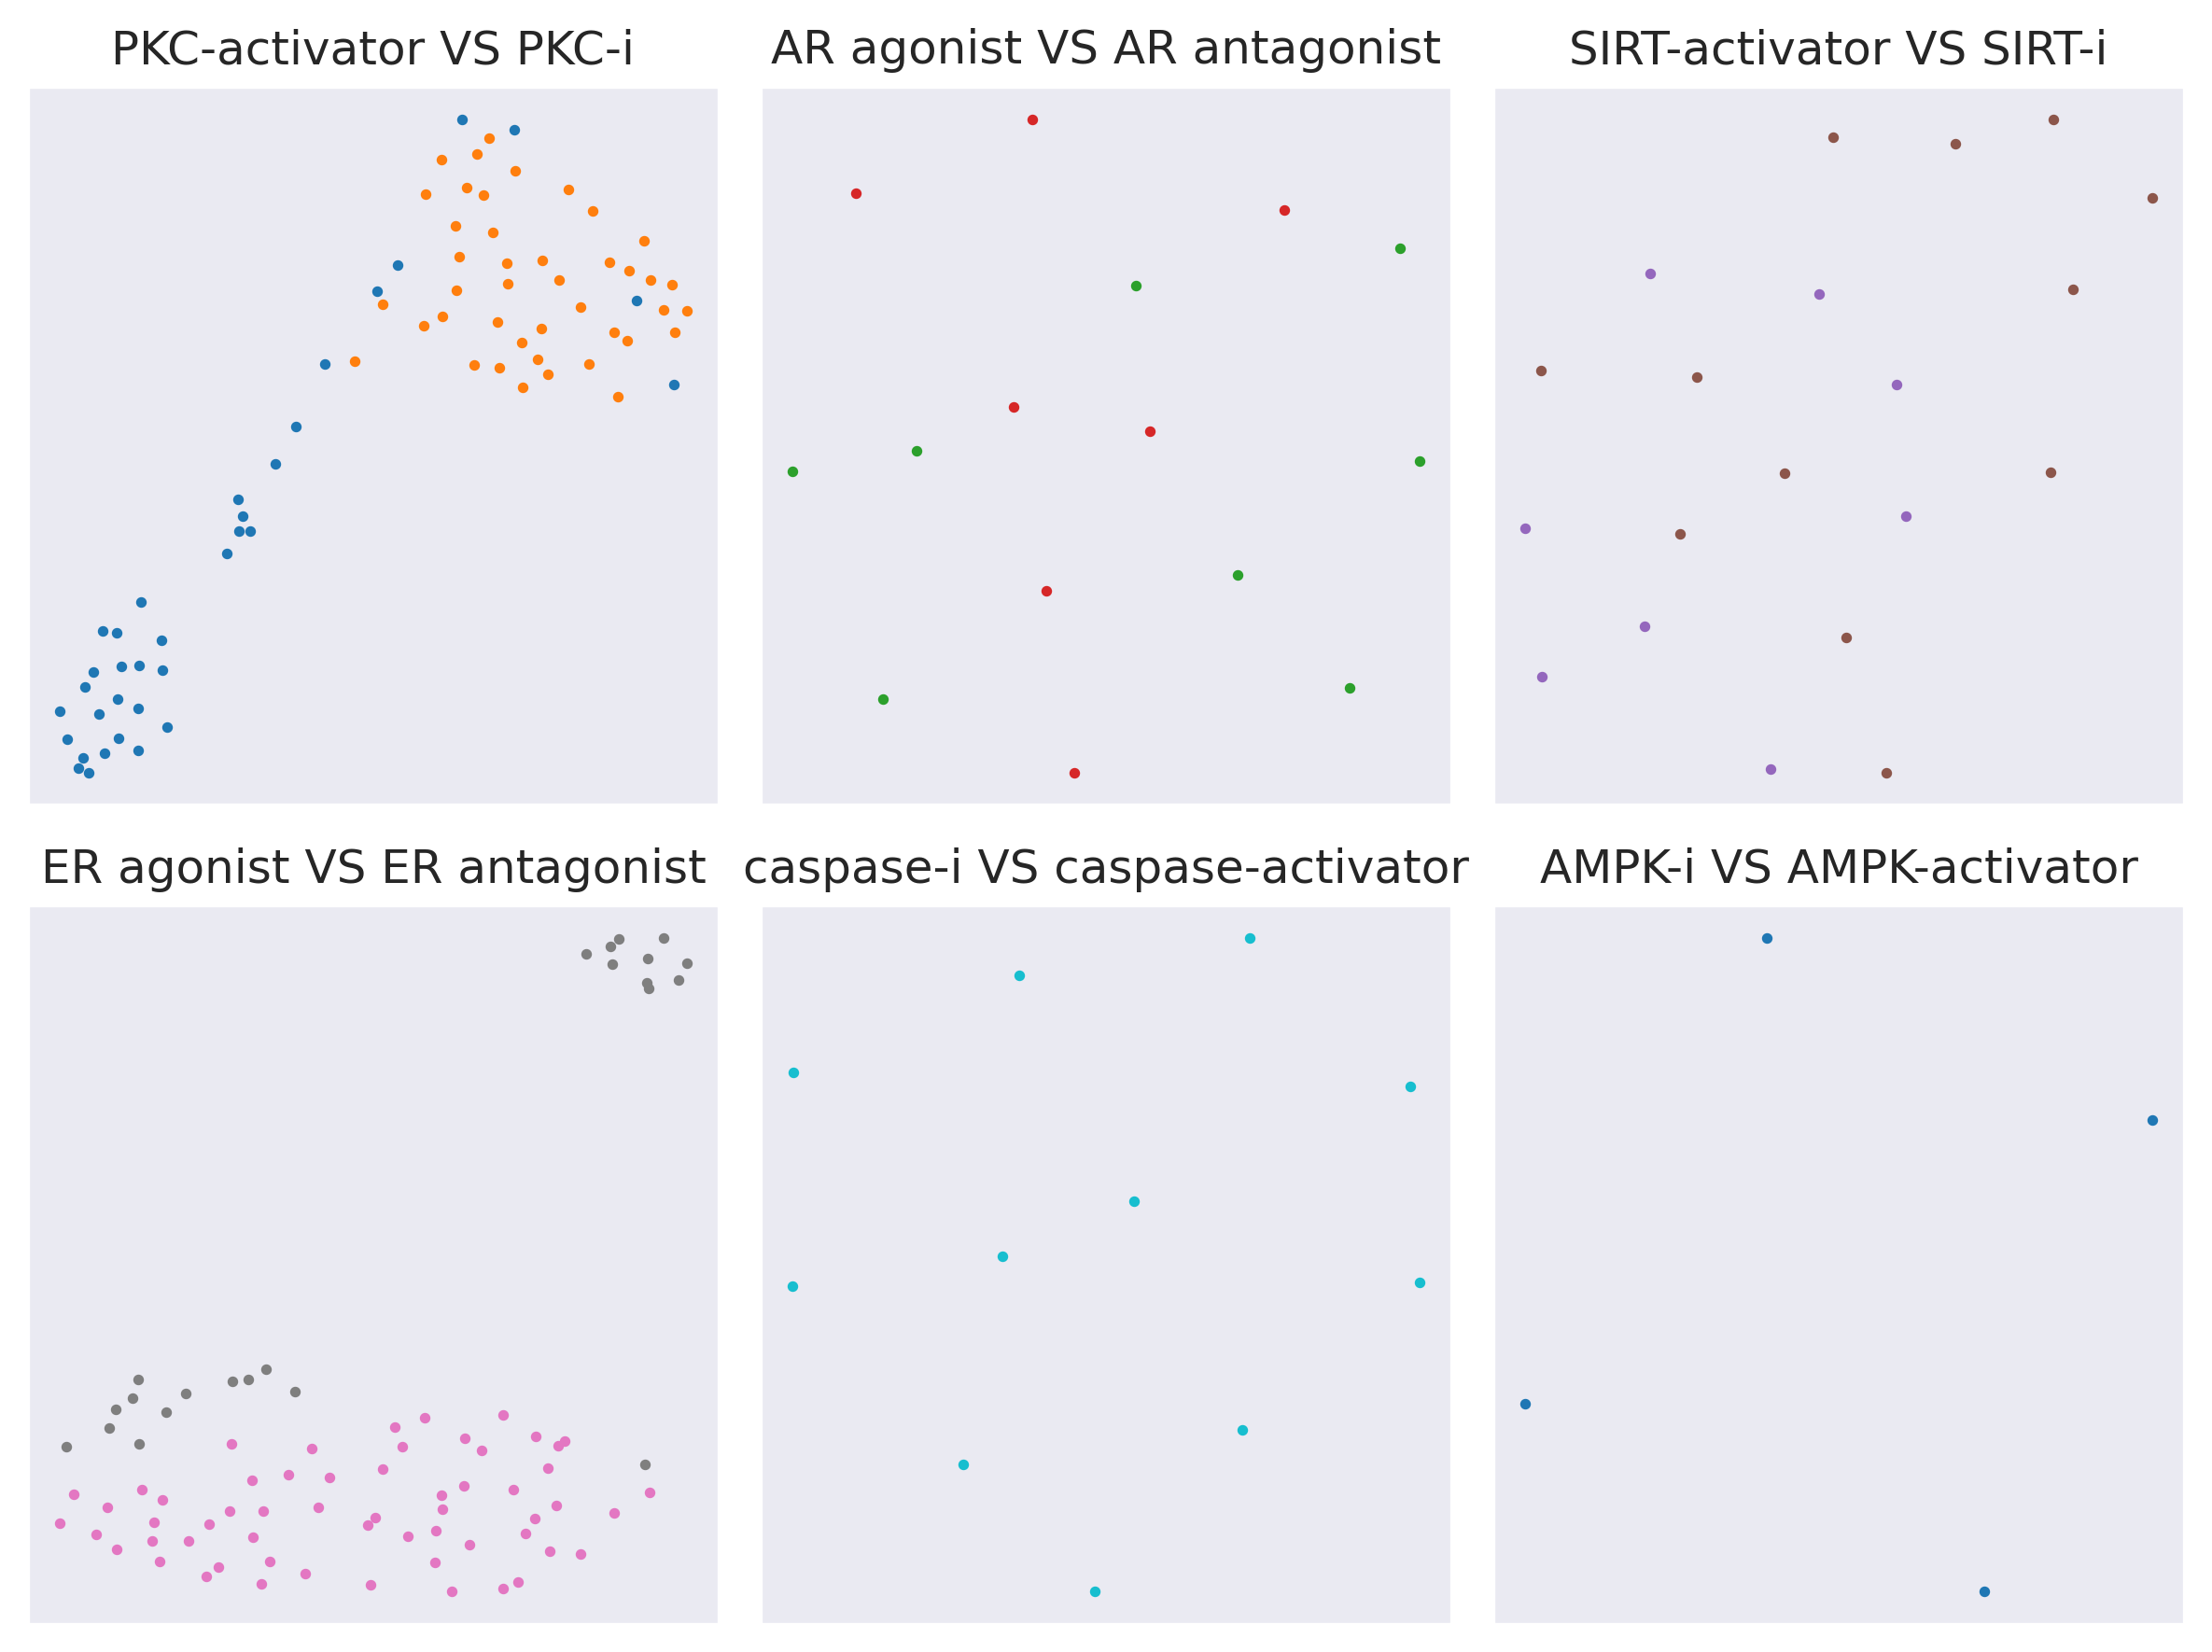

In [8]:
my_dpi=300
plt.figure(figsize=(8,6),dpi=my_dpi)

plt.subplot(231)
X_tsne = p1_x
y = y1
for i in moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3)#,label = name_dict[i],color=col_map[i] )

plt.title('{} VS {}'.format(pair1_moas[0],pair1_moas[1]))
plt.xticks([],[])
plt.yticks([],[])
# plt.xlabel('TSNE-1')
# plt.ylabel('TSNE-2')

plt.subplot(232)
X_tsne = p2_x
y = y2
for i in moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3)#,label = name_dict[i],color=col_map[i] )
plt.title('{} VS {}'.format(pair2_moas[0],pair2_moas[1]))
plt.xticks([],[])
plt.yticks([],[])
# plt.xlabel('TSNE-1')
# plt.ylabel('TSNE-2')

plt.subplot(233)
X_tsne = p3_x
y = y3
for i in moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3)#,label = name_dict[i],color=col_map[i] )
    plt.xticks([],[])
plt.title('{} VS {}'.format(pair3_moas[0],pair3_moas[1]))
plt.yticks([],[])
# plt.xlabel('TSNE-1')
# plt.ylabel('TSNE-2')

plt.subplot(234)
X_tsne = p4_x
y = y4
for i in moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3)#,label = name_dict[i],color=col_map[i] )

plt.title('{} VS {}'.format(pair4_moas[0],pair4_moas[1]))
plt.xticks([],[])
plt.yticks([],[])
# plt.xlabel('TSNE-1')
# plt.ylabel('TSNE-2')

plt.subplot(235)
X_tsne = p5_x
y = y5
for i in moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3)#,label = name_dict[i],color=col_map[i] )

plt.title('{} VS {}'.format(pair5_moas[0],pair5_moas[1]))
plt.xticks([],[])
plt.yticks([],[])
# plt.xlabel('TSNE-1')
# plt.ylabel('TSNE-2')

plt.subplot(236)
X_tsne = p6_x
y = y6
for i in moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3)#,label = name_dict[i],color=col_map[i] )

plt.title('{} VS {}'.format(pair6_moas[0],pair6_moas[1]),fontsize=5)
plt.xticks([],[])
plt.yticks([],[])
# plt.xlabel('TSNE-1')
# plt.ylabel('TSNE-2')

plt.tight_layout()
plt.show()

In [12]:
#############
# get data
#############
cell = 'MCF7'
fold = 2
data_dir = '/home/jlk/Project/111_Cmap/MOA/'
data_info_dir = '{}/data/01_Info_file/'.format(data_dir)
data_all_dir = '{}/data/02_All_data/'.format(data_dir)
data_cell_dir = '{}/data/03_Single_Cell/'.format(data_dir)
sig2drugmoa_file = '{}/sig2drugmoa.npz'.format(data_info_dir)
drug2moa_file = '{}/drug2moa.npz'.format(data_info_dir)

###############
# train data
#
train_file = '{}/{}/Train_fold_{}.h5'.format(data_cell_dir,cell,fold)
test_file = '{}/{}/Test_fold_{}.h5'.format(data_cell_dir,cell,fold)

sig2drugmoa_dict = np.load(sig2drugmoa_file)
drug2moa_dict = np.load(drug2moa_file)
train_df = pd.read_hdf(train_file)
test_df = pd.read_hdf(test_file)
print('Train & Test before train',train_df.shape,test_df.shape)


Train & Test before train (2931, 12328) (1818, 12328)


In [13]:
#############
# stat moa
#############
moas = ['HDAC-i','HSP-i','MEK/ERK-i','PKC-activator','Topo-i','antimetabolite','antimicrotubule',
        'retinoid','proteasome inh.','mTOR-i','PKC-activator','PKC-i',
        'AR agonist','AR antagonist',
        'SIRT-activator','SIRT-i',
        'ER agonist','ER antagonist',
        'caspase-i','caspase-activator',
        'AMPK-i','AMPK-activator']


train_sigs = train_df.index
train_moas = [sig2drugmoa_dict[i][1] for i in train_sigs]
moa_counts = Counter(train_moas)
# print('### There are {} moas!'.format(len(moa_counts)))

for moa in moas:
    print(moa,moa_counts[moa])

HDAC-i 232
HSP-i 100
MEK/ERK-i 121
PKC-activator 19
Topo-i 192
antimetabolite 66
antimicrotubule 83
retinoid 73
proteasome inh. 379
mTOR-i 156
PKC-activator 19
PKC-i 15
AR agonist 0
AR antagonist 0
SIRT-activator 0
SIRT-i 0
ER agonist 31
ER antagonist 21
caspase-i 0
caspase-activator 0
AMPK-i 0
AMPK-activator 0


In [14]:
moas = ['HDAC-i','HSP-i','MEK/ERK-i','PKC-activator','Topo-i','antimetabolite','antimicrotubule',
        'retinoid','proteasome inh.','mTOR-i','PKC-i',
        'ER agonist','ER antagonist']

train_sigs = train_df.index
train_moas = [sig2drugmoa_dict[i][1] for i in train_sigs]
moa_counts = Counter(train_moas)
# print('### There are {} moas!'.format(len(moa_counts)))

for moa in moas:
    print(moa,moa_counts[moa])

HDAC-i 232
HSP-i 100
MEK/ERK-i 121
PKC-activator 19
Topo-i 192
antimetabolite 66
antimicrotubule 83
retinoid 73
proteasome inh. 379
mTOR-i 156
PKC-i 15
ER agonist 31
ER antagonist 21


In [16]:
##################
# before train data
##################
plot_train_index = np.where(np.isin(train_moas,moas),True,False)
plot_train_data = train_df.loc[plot_train_index]

plot_train_x = plot_train_data.values
plot_train_y = [sig2drugmoa_dict[i][1] for i in plot_train_data.index]
plot_train_y = np.array(plot_train_y)

In [23]:
! pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 8.2 MB/s eta 0:00:0000:0100:01m


/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/jlk/Software/anaconda3/envs/Deepmetric/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: The palette list has more values (24) than needed (13), which may not be intended.
  # Remove the CWD from sys.path while we load stuff.


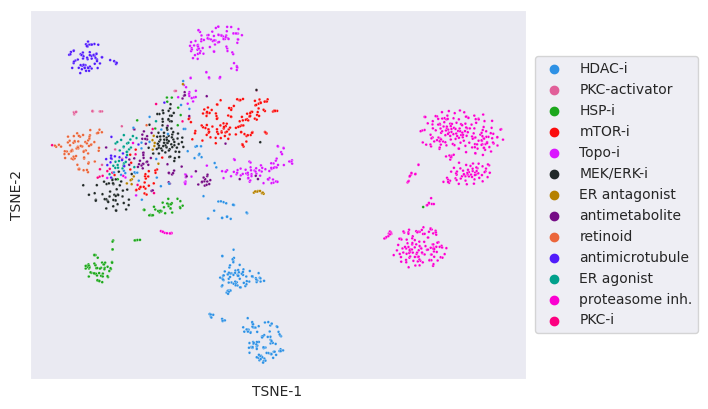

In [34]:
#################
# before train plot TSNE
#################
import plotly.express as px

X = TSNE(n_components=2).fit_transform(plot_train_x)
df = pd.DataFrame(X)
df.columns = ['x','y']
df['l'] = plot_train_y
sns.scatterplot(data=df,x='x',y='y',hue='l',s=4,palette = px.colors.qualitative.Dark24)
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.legend(bbox_to_anchor=(1.005, 0.5), loc='center left')
plt.show()